# Import libraries

In [11]:
from notebooks.functions.tools import load_json
import pandas as pd
import time
from unidecode import unidecode
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

# Global variables

In [2]:
n_ofertas = 10000
index_chars = 2
filename = "test"

# Import test set and dictionaries

In [3]:
data = load_json('./data/RAW/TEST_10K.json')
# Now cast data to a DataFrame
test_df = pd.DataFrame(data)
print(test_df.shape)
test_df.head()
sustantives_df = pd.read_csv('./data/diccionario/df_structured_sustantivos.csv')
adjectives_df = pd.read_csv('./data/diccionario/df_structured_adjetivos.csv')
adverbs_df = pd.read_csv('./data/diccionario/df_structured_adverbios.csv')
verbs_df = pd.read_csv('./data/diccionario/df_structured_verbos.csv')
# Read the txt files sustantives and adjectives
with open('./data/diccionario/list_unstructured_sustantivos.txt', 'r') as f:
    sustantives_forms = f.read().splitlines()
with open('./data/diccionario/list_unstructured_adjetivos.txt', 'r') as f:
    adjectives_forms = f.read().splitlines()
# with open('./data/diccionario/list_unstructured_verbs.txt', 'r') as f:
#     verbs_forms = f.read().splitlines()
with open('./data/diccionario/list_unstructured_adverbios.txt', 'r') as f:
    adverbs_forms = f.read().splitlines()
# Get the spanish stopwords with nltk
stop_words = stopwords.words('spanish')
# Cast all word to unicode
sustantives_forms = [unidecode(word) for word in sustantives_forms]

(11528, 9)


# Fix verbs df

In [4]:
# Delete all samples that a one of the columns is null in verbs_df
print("Before: ", verbs_df.shape)
verbs_df = verbs_df.dropna()
# Find all the verbs that have a space in the column "FORMA" and delete them
verbs_df = verbs_df[verbs_df['FORMA'].str.contains(' ') == False]
print("After: ", verbs_df.shape)
verbs_df = verbs_df.sort_values(by=['FORMA']).reset_index(drop=True)
# Get the list of verbs in the column "FORMA"
verbs_forms = verbs_df['FORMA'].tolist()

Before:  (1021406, 2)
After:  (554143, 2)


In [5]:
# Get the index of the verbs that are in the list of verbs_forms
verb = "hara"
index = verbs_forms.index(verb)
# Get the INF value of the verb
inf = verbs_df.iloc[index]['INF']
print(inf)

hacer


# Clean test

In [6]:
import re

list_remove = ["www", "com","http", "https"]

def tokenize_descripcion(text):
    # Remove links (URLs) from the text using regular expressions
    text = re.sub(r'http(s)?:\s+\S+', '', text, flags=re.IGNORECASE)
    # Remove all occurrences of ".es" (case-insensitive)
    text = re.sub(r'\.es', '', text, flags=re.IGNORECASE)
    # Remove all non alpha characters from the text using regular expressions
    text = re.sub(r'[^a-zA-Z ]+', ' ', text, flags=re.IGNORECASE)
    # Remove unnecessary spaces from the text using regular expressions
    text = re.sub(r'\s+', ' ', text, flags=re.IGNORECASE)
    # Cast all words to lowercase
    text = text.lower()
    return text

def create_palabras_column(text):
    # Split the text into a list of words and filter simultaneously
    palabras = [palabra for palabra in text.split(" ") if len(palabra) > 1 and palabra not in list_remove]
    return palabras

def list_words(palabras_empleo_texto):
    # print(palabras_empleo_texto)
    try:
        return palabras_empleo_texto.lower().split(" ")[:-1]
    except:
        return []

def clean_descripcion(df):
    # tokenize the descripcion
    df['descripcion_oferta'] = df['descripcion_oferta'].apply(tokenize_descripcion)
    # Split the text into a list of words
    df['palabras_descripcion_oferta'] = df['descripcion_oferta'].apply(create_palabras_column)
    # Convert the string into a list
    df['palabras_empleo_texto'] = df['palabras_empleo_texto'].apply(lambda x: list_words(x))
    return df

test_df = clean_descripcion(test_df)

# Indexialice unstructured lists

In [7]:
def create_index_list(unstructured_forms):
    if index_chars == 0:
        return {}
    index_list = {}
    for index, string in enumerate(unstructured_forms):
        first_letter = string[0:index_chars]
        if first_letter not in index_list:
            index_list[first_letter] = index
    return index_list

def find_indices(string, index_list, unstructured_forms):
    if index_chars == 0:
        return {}
    if not string:  # Check if the string is empty
        return 0, len(unstructured_forms)
    first_letter = string[0:index_chars]
    start_index = index_list.get(first_letter, 0)
    if first_letter in limit_letters:
        end_index = len(unstructured_forms)
    else:
        next_letter = get_next_letter(first_letter, index_list)
        end_index = index_list.get(next_letter, len(unstructured_forms))
    return start_index, end_index

def get_next_letter(first_letter, index_list):
    keys_list = list(index_list.keys())
    if first_letter in keys_list:
        next_letter_index_key = keys_list.index(first_letter) + 1
        return keys_list[next_letter_index_key]
    else:
        return chr(ord(first_letter[0]) + 1)

sustantives_index_list = create_index_list(sustantives_forms)
adjectives_index_list = create_index_list(adjectives_forms)
verbs_index_list = create_index_list(verbs_forms)
# Get the first two letters of the column FORMA on each DataFrame
limit_letters = [verbs_df['FORMA'].str[0:index_chars].iloc[-1],
                 sustantives_df['FORMA'].str[0:index_chars].iloc[-1],
                 adjectives_df['FORMA'].str[0:index_chars].iloc[-1]]
print(limit_letters)

['zu', 'zz', 'zu']


# Test functions

In [8]:
def clean_word(word):
    # Delete all numbers
    word = re.sub(r"\d+", "", word)
    # Delete all accents
    word = unidecode(word.lower())
    # Remove simbols
    word = re.sub(r"[^a-z0-9ñ]", "", word)
    return word

def get_reference(descripcion_oferta, df, index, column):
    # Get the accuracy of the words in palabras_empleo_texto that are in descripcion_oferta
    error = 0
    accuracy = 0
    if column == "palabras_empleo_texto":
        list_words = df[column].iloc[index]
    else:
        list_words = df[column].iloc[index].lower().split(" ")
    
    for word in descripcion_oferta.split(" "):
        if unidecode(word) not in list_words:
            error += 1
        else:
            accuracy += 1
    return error, accuracy

def add_words_to_vocabulary(palabras_list, vocabulary):
    # Add to vocabulary all different words
    for palabra in palabras_list:
        if palabra not in vocabulary.keys():
            vocabulary[palabra] = 1
        else:
            vocabulary[palabra] += 1
    # Return the vocabulary
    return vocabulary

def show_process_stats(end_time_process, times, palabras, metrics, vocabulary):
    # Print total of offers
    print("Total of offers: {:.0f}".format(len(times)))
    # Print the time process
    print("Time process: {:.2f} seg".format(end_time_process))
    # Get mean of times
    mean_time = sum(times) / len(times)
    print("Mean time: {:.2f} seg".format(mean_time))
    # Sum all the words is a list of lists
    total_words = sum(palabras)
    print("Total words: {:.0f}".format(total_words))
    # Get words per time
    words_per_time = total_words / end_time_process
    print("Words per time: {:.2f}".format(words_per_time))
    # Total number of different words
    total_different_words = len(vocabulary.keys())
    print("Total different words: {:.0f}".format(total_different_words))
    # Get the mean of er_nuevas, acc_nuevas, er_legacy, acc_legacy
    er_nuevas = sum([metric["er_nuevas"] for metric in metrics]) / len(metrics)
    acc_nuevas = sum([metric["acc_nuevas"] for metric in metrics]) / len(metrics)
    er_legacy = sum([metric["er_legacy"] for metric in metrics]) / len(metrics)
    acc_legacy = sum([metric["acc_legacy"] for metric in metrics]) / len(metrics)
    # Print the metrics
    print("Error medio producido en palabras nuevas: {:.2f}".format(er_nuevas))
    print("Precisión media obtenida en palabras nuevas: {:.2f}".format(acc_nuevas))
    print("Error medio anterio: {:.2f}".format(er_legacy))
    print("Precisión media anterior: {:.2f}".format(acc_legacy))

def create_excel_file(filename, end_time_process, times, n_palabras_total, n_palabras_encontradas, metrics, vocabulary):
    # Create a dictionary with the data
    data = {
        'NOMBRE_TEST': [filename],
        'INDEXACIÓN [n_letras]': index_chars,
        'N_OFERTAS': [len(times)],
        'WORDS_DESCRIPCION [n_palabras]': [sum(n_palabras_total)],
        'WORDS_ENCONTRADAS [n_palabras]': [sum(n_palabras_encontradas)],
        'TIME_PROCESS [seg]': [end_time_process],
        'MEAN_TIME [seg]': [sum(times) / len(times)],
        'WORDS_PER_TIME_DESCRIPTION [n_palabras/seg]': [sum(n_palabras_total) / end_time_process],
        'MEAN_PRECISION': [sum([metric["acc_nuevas"] for metric in metrics]) / len(metrics)],
        'MEAN_ERRORES': [sum([metric["er_nuevas"] for metric in metrics]) / len(metrics)],
        'TOTAL_TIME_PALABRAS [horas]': [sum(times) / len(times) * 50000 / 36000],  # Convert seconds to hours
        'VOCABULARIO [n_palabras_distintas]': [len(vocabulary.keys())]
    }
    print(n_palabras_total)
    print(n_palabras_encontradas)
    # Create a DataFrame
    df = pd.DataFrame(data)
    # Save the DataFrame to an Excel file
    df.to_excel('./test/' + filename + '.xlsx', index=False)
    
def update_excel_file(filename, end_time_process, times, n_palabras_total, n_palabras_encontradas, metrics, vocabulary):
    try:
        # Load the existing Excel file if it exists
        df = pd.read_excel('./test/' + filename + '.xlsx')
    except FileNotFoundError:
        # Create a new DataFrame if the file doesn't exist
        df = pd.DataFrame()

    # Create a dictionary with the new data
    new_data = {
        'NOMBRE_TEST': [filename],
        'INDEXACIÓN [n_letras]': index_chars,  # Replace with your actual data
        'N_OFERTAS': [len(times)],
        'WORDS_DESCRIPCION [n_palabras]': [sum(n_palabras_total)],
        'WORDS_ENCONTRADAS [n_palabras]': [sum(n_palabras_encontradas)],
        'TIME_PROCESS [seg]': [end_time_process],
        'MEAN_TIME [seg]': [sum(times) / len(times)],
        'WORDS_PER_TIME_DESCRIPTION [n_palabras/seg]': [sum(n_palabras_total) / end_time_process],
        'MEAN_PRECISION': [sum([metric["acc_nuevas"] for metric in metrics]) / len(metrics)],
        'MEAN_ERRORES': [sum([metric["er_nuevas"] for metric in metrics]) / len(metrics)],
        'TOTAL_TIME_PALABRAS [horas]': [sum(times) / len(times) * 50000 / 36000],  # Convert seconds to hours
        'VOCABULARIO [n_palabras_distintas]': [len(vocabulary.keys())]
    }

    # Convert the new data to a DataFrame
    new_df = pd.DataFrame(new_data)

    # Concatenate the existing DataFrame with the new DataFrame
    df = pd.concat([df, new_df], ignore_index=True)

    # Save the updated DataFrame back to the Excel file
    df.to_excel('./test/' + filename + '.xlsx', index=False)

def get_lemma_df(word, df, unstructured_forms, index_list):
    if index_chars == 0:
        start, end = (0, len(unstructured_forms))
    else:
        start, end = find_indices(word, index_list, unstructured_forms)
    # Is faster to handler the exception than to check if the word is in the list
    try:
        index = unstructured_forms.index(word, start, end)
        if "LEMA" in df.columns:
            return df.iloc[index]["LEMA"]
        else:
            return df.iloc[index]["INF"]
    except:
        return None

def conditional_inference(word, df_nouns, unstructured_forms_nouns, df_adj, unstructured_forms_adj, df_verbs, unstructured_forms_verb):
    verb = get_lemma_df(word, df_verbs, unstructured_forms_verb, verbs_index_list)
    if verb == None:
        noun = get_lemma_df(word, df_nouns, unstructured_forms_nouns, sustantives_index_list)
        if noun == None:
            adjective = get_lemma_df(word, df_adj, unstructured_forms_adj, adjectives_index_list)
            if adjective == None:
                return None
            else:
                return adjective
        else:
            return noun
    else:
        return verb

def get_syntax(words, df_nouns, unstructured_forms_nouns, df_adj, unstructured_forms_adj, unstructured_forms_adv, df_verbs, unstructured_forms_verb):
    # Object palabras_list
    palabras_list = []
    # Split by " "
    for word in words.split(" "):
        word = clean_word(word)
        if word in stop_words or word in unstructured_forms_adv:
            continue
        # Verify if is a noun
        solution = conditional_inference(word, df_nouns, unstructured_forms_nouns, df_adj, unstructured_forms_adj, df_verbs, unstructured_forms_verb)
        if solution != None:
            palabras_list.append(solution)
    return palabras_list

def process_and_update_df(filename, df, sustantives_df, sustantives_forms, adjectives_df, adjectives_forms, adverbs_forms ,verbs_df, verbs_forms):
    import time
    # Create a new column in the DataFrame to store the result
    df["palabras_empleo_texto_nuevas"] = ""
    times = []
    n_palabras_total = []
    n_palabras_encontradas = []
    metrics = []
    vocabulary = {}
    start_time_process = time.time()
    # Iterate over the DataFrame and apply the word extraction function
    for index, description in df["descripcion_oferta"].items():
        start_time = time.time()
        # Get the list of words
        palabras_list = get_syntax(description, sustantives_df, sustantives_forms, adjectives_df, adjectives_forms, adverbs_forms ,verbs_df, verbs_forms)
        # Add the words to the vocabulary
        vocabulary = add_words_to_vocabulary(palabras_list, vocabulary)
        # Save palabras_list in a new column in the DataFrame, insert the full list
        df.at[index, "palabras_empleo_texto_nuevas"] = ' '.join(palabras_list).upper()
        # Calculate partial time and save to times list
        times.append(time.time() - start_time)
        # Save the number of words in the list
        n_palabras_total.append(len(description.split(" ")))
        n_palabras_encontradas.append(len(palabras_list))
        # Get the metrics of the calculated words
        er_nuevas, acc_nuevas = get_reference(description, df, index, "palabras_empleo_texto_nuevas")
        # Get the metrics of the legacy words
        er_legacy, acc_legacy = get_reference(description, df, index, "palabras_empleo_texto")
        # Add to metrics list
        metrics.append({"er_nuevas": er_nuevas, "acc_nuevas": acc_nuevas, "er_legacy": er_legacy, "acc_legacy": acc_legacy})
    # Calculate and add the column with words that appear in palabras legacy but not in palabras nuevas
    df["palabras_legacy_minus_nuevas"] = df.apply(lambda row: list(set(row["palabras_empleo_texto"]) - set(row["palabras_empleo_texto_nuevas"])), axis=1)
    end_time_process = time.time() - start_time_process
    # show_process_stats(end_time_process, times, n_palabras, metrics, vocabulary)
    create_excel_file(filename, end_time_process, times, n_palabras_total, n_palabras_encontradas, metrics, vocabulary)
    return df, times, n_palabras_encontradas, vocabulary

# Test

In [9]:
# Get the first 5 rows of the DataFrame and save into a new DataFrame
partial_df = test_df.iloc[0:n_ofertas].copy()
# Call the processing function with your DataFrame
partial_df, time_list, n_palabras, vocabulary = process_and_update_df(filename, partial_df, sustantives_df, sustantives_forms, adjectives_df, adjectives_forms, adverbs_forms ,verbs_df, verbs_forms)
partial_df.head(5)

[21, 49, 41, 47, 192, 230, 148, 103, 173, 93, 78, 167, 25, 277, 44, 59, 162, 154, 86, 256, 170, 139, 41, 129, 65, 104, 30, 251, 29, 187, 104, 119, 144, 316, 316, 83, 135, 234, 106, 110, 122, 47, 74, 135, 53, 77, 47, 65, 134, 186, 152, 274, 251, 81, 296, 251, 145, 106, 251, 251, 181, 56, 169, 251, 244, 66, 251, 251, 70, 100, 94, 56, 228, 251, 188, 143, 92, 186, 25, 102, 171, 138, 87, 88, 296, 63, 128, 251, 103, 53, 131, 316, 75, 19, 33, 316, 251, 228, 26, 316, 251, 251, 19, 178, 201, 66, 82, 147, 313, 95, 205, 40, 312, 201, 113, 113, 98, 74, 51, 40, 157, 90, 200, 27, 356, 119, 15, 166, 167, 186, 20, 22, 51, 63, 32, 37, 78, 124, 45, 30, 49, 26, 24, 18, 64, 193, 86, 49, 44, 69, 16, 69, 191, 250, 15, 195, 119, 126, 297, 60, 58, 258, 129, 123, 108, 115, 88, 186, 349, 15, 53, 441, 24, 234, 150, 59, 97, 214, 92, 206, 247, 64, 49, 234, 91, 107, 103, 20, 36, 31, 138, 41, 164, 20, 66, 187, 129, 213, 18, 46, 72, 193, 217, 26, 79, 189, 115, 122, 455, 67, 218, 121, 228, 341, 58, 69, 139, 228, 243, 

,id_oferta,categoria,subcategoria,asunto,requisitos_minimos,descripcion_oferta,skills,palabras_empleo_texto,requisitos_deseados,palabras_descripcion_oferta,palabras_empleo_texto_nuevas,palabras_legacy_minus_nuevas
0,26f936c381465f8b1c479264c4731c,Ingenieros y tecnicos,Industrial,INGENIERO SUPERIOR O DIRECTOR DE SEGURIDAD,"Ingeniero superior, grado + máster en ingenier...",ingeniero superior o director de seguridad con...,SEGURIDAD FISICA,[],None,"[ingeniero, superior, director, de, seguridad,...",INGENIERO SUPERIOR DIRECTOR SEGURIDAD EXPERIEN...,[]
1,b19e15055c43ebb9e07e30fb952724,Atencion a clientes,Atencion al cliente,Administrativo/a,None,buscamos una persona encargada de gestionar la...,Archivo Facturación Gestión de correspondenci...,"[administrativo, persona, reservas, buceo, ges...",None,"[buscamos, una, persona, encargada, de, gestio...",BUSCAR PERSONA ENCARGADO GESTIONAR RESERVAR AC...,"[atenciones, reservas, fisica, facturaciones, ..."
2,f390055aeb48c8811ced58606cf3b1,Ventas al detalle,Venta al detalle,Dependiente/a,None,se busca dependiente para la tienda tezenis en...,None,"[dependiente, tiendas, centro, comercial, expe...",None,"[se, busca, dependiente, para, la, tienda, tez...",BUSCAR DEPENDIENTE TENDER CENTRAR COMERCIAL ME...,"[tiendas, dependiente, idiomas, sector, centro..."
3,a2ea91dd7c45c2a30e94326473e61b,Turismo y restauracion,Restauracion,Cocinero/a,None,se requiere cocinero salario superior a conven...,None,[],None,"[se, requiere, cocinero, salario, superior, co...",REQUERIR COCINERO SALARIAR SUPERIOR CONVENIO R...,[]
4,bbff55cb0f44fea833fc8524b3f1a4,Recursos humanos,Prevencion de riesgos,Formador/a Freelance PRL - Canarias,-Experiencia en la impartición de cursos de ma...,grupo loxamhune empresa lider en el alquiler d...,Prevención de riesgos laborales Maquinaria,"[puentes, grua, normas, sector, metales, homol...",None,"[grupo, loxamhune, empresa, lider, en, el, alq...",EMPRESA LIDER ALQUILER MAQUINAR PLATAFORMA ELE...,"[carretillas, puentes, freelance, empresas, ri..."


# Export results

In [10]:
test_df.to_csv("./data/test/test_palabras_nuevas.csv", index=False)


def export_results_to_markdown(index, test_df, output_file, time):
    # Get list of words in descripcion_oferta
    descripcion_oferta = test_df["descripcion_oferta"].iloc[index]
    error, accuracy = get_reference(descripcion_oferta, test_df, index, "palabras_empleo_texto_nuevas")
    
    with open("./test/" + str(index) + "_" + output_file, "w") as md_file:
        # Write header for the section
        md_file.write(f"## Descripcion oferta: \n{test_df['descripcion_oferta'].iloc[index]}\n")
        md_file.write(f"### Total de palabras en descripción: \n{len(descripcion_oferta)}\n")
        md_file.write(f"\n")
        md_file.write(f"## Palabras nuevas: \n{test_df['palabras_empleo_texto_nuevas'].iloc[index]}\n")
        md_file.write(f"### Accuracy - palabras nuevas: \n{accuracy}\n")
        md_file.write(f"### Error - palabras nuevas: \n{error}\n")
        palabras_not_found = list(set(test_df['palabras_empleo_texto_nuevas'].iloc[index].lower().split(" ")) - set(descripcion_oferta.split(" ")))
        md_file.write(f"## Palabras nuevas no encontradas en descripción: \n{', '.join(palabras_not_found)}\n")
        md_file.write(f"\n")
        error, accuracy = get_reference(descripcion_oferta, test_df, index, "palabras_empleo_texto")
        md_file.write(f"## Palabras legacy: \n{', '.join(test_df['palabras_empleo_texto'].iloc[index])}\n")
        md_file.write(f"### Accuracy - palabras legacy: \n{accuracy}\n")
        md_file.write(f"### Error - palabras legacy: \n{error}\n")
        palabras_not_found = list(set(test_df['palabras_empleo_texto'].iloc[index]) - set(descripcion_oferta))
        md_file.write(f"## Palabras legacy no encontradas en descripción: \n{', '.join(palabras_not_found)}\n")
        md_file.write(f"\n")
        md_file.write(f"## Tiempo de ejecución: \n{time} segundos\n")
        md_file.write(f"## Relación palabras/tiempo: \n{len(descripcion_oferta)/time} palabras/segundo\n")

# Define the Markdown output file
output_file = "test.md"

# Call the function to export the results to Markdown
for index in range(0, 5):
    time = time_list[index]
    export_results_to_markdown(index, partial_df, output_file, time)

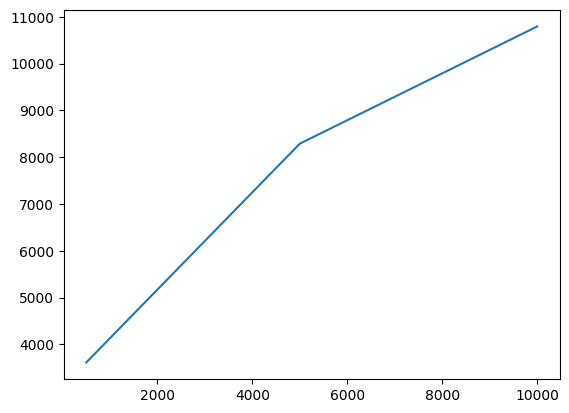

In [12]:
x_axis = [500, 5000, 10000]
y_axis = [3613, 8290, 10794]
# Plot the results
plt.plot(x_axis, y_axis)